# Efficient Route Planning algorithm

Importing useful libraries

In [27]:
import os
import math
import datetime
import pandas as pd
import numpy as np
pd.set_option("display.max_columns", 50)

import matplotlib.pyplot as plt
%matplotlib inline
                                                                                                
import plotly.express as px
import plotly.graph_objects as go

import warnings
warnings.filterwarnings("ignore")

In [28]:
%load_ext sparkmagic.magics

The sparkmagic.magics extension is already loaded. To reload it, use:
  %reload_ext sparkmagic.magics


In [29]:
%spark cleanup

Setting up the Hive environment

In [30]:
import os
from IPython import get_ipython
username = os.environ['RENKU_USERNAME']
server = "http://iccluster044.iccluster.epfl.ch:8998"

# set the application name as "<your_gaspar_id>-homework3"
get_ipython().run_cell_magic(
    'spark',
    line='config', 
    cell="""{{ "name": "{0}-ER", "executorMemory": "4G", "executorCores": 4, "numExecutors": 10, "driverMemory": "4G" }}""".format(username)
)

Connecting to the cluster on Spark

In [31]:
get_ipython().run_line_magic(
    "spark", f"""add -s {username}-finalproject-1 -l python -u {server} -k"""
) 

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
6980,application_1680948035106_6392,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


Importing useful libraries on Spark as well

In [32]:
%%spark
import math
import numpy as np
import pyspark.sql.functions as SFunc
import pyspark.sql.functions as F
from pyspark.sql import Window
import matplotlib.pyplot as plt
from datetime import datetime
import time

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Define the day and time of desired arrival with the desired confidence 

In [33]:
%%spark 

day = 'tuesday'
arrival_time = '18:00:00'
conf_int = 0.8

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Creating table containing stops close to Zurich HB (radius 15 km)

As computed in data_preparation, we have the floowing data for Zurich HB:

- lat_Zur = 47.378178
- lon_Zur = 8.540212

We will use a computation similar to the one in data_preparation

In [34]:
%%spark
circ = 40075.0

@SFunc.udf
def distance(lat1, lon1, lat2=47.378177, lon2=8.540192, circ=circ):
    """
    Compute the distance of two stop stations based on their latitude and longitude.
    """
    km_per_degree_lat = circ / 360.0
    km_per_degree_lon = math.cos(math.pi * lat2 / 180.0) * km_per_degree_lat
    dx = abs(lon2 - lon1) * km_per_degree_lon
    dy = abs(lat2 - lat1) * km_per_degree_lat
    return math.sqrt(dx*dx + dy*dy)


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

We now load the dataset containing information containing all the stops in Switzerland and we keep only those whithin a radius of 15 Kms from Zurich HB (Central Sation in Zurich).

In [36]:
%%spark -o stops_in_zurich

max_dist=15.0

stops_in_zurich = spark.read.orc("/data/sbb/orc/allstops")
stops_in_zurich = stops_in_zurich.withColumn('distance', distance(stops_in_zurich['stop_lat'], stops_in_zurich['stop_lon'])).filter(SFunc.col('distance') <= max_dist)
stops_in_zurich = stops_in_zurich.drop('location_type', 'parent_station')

# we now extract station id and name that will be used in later computations and filtering.
ids_in_zurich = set([str(stop.stop_id) for stop in stops_in_zurich.select('stop_id').collect()])
names_in_zurich = set([str(stop.stop_name) for stop in stops_in_zurich.select('stop_name').collect()])
stops_in_zurich.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+--------------------+----------------+----------------+------------------+
|  stop_id|           stop_name|        stop_lat|        stop_lon|          distance|
+---------+--------------------+----------------+----------------+------------------+
|      176|Zimmerberg-Basist...|47.3516780901371|8.52195777551452| 3.254358795054443|
|  8500926|Oetwil a.d.L., Sc...|47.4236270123012| 8.4031825286317|11.500566308438826|
|  8502075|Zürich Flughafen,...|47.4510244676285|8.56372943623189| 8.301169459254064|
|  8502186|Dietikon Stoffelbach|47.3933267759652|8.39896044679575|10.778877635541626|
|8502186:0|Dietikon Stoffelbach|47.3933997509195|8.39894248049007|10.781489106921216|
+---------+--------------------+----------------+----------------+------------------+
only showing top 5 rows

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Load other tables

![tables interactions](figs/other_tables.png)

In [37]:
%%spark
# we filter the calendar to keep only trips available during the selected day
calendar = spark.read.csv("../../user/bocini/ER/calendar", header = True, encoding = 'utf8')
# remove later:
#calendar = calendar.rdd.flatMap(lambda x: x).collect()
calendar = calendar.filter("{0} == 1".format(day)).select('service_id')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [38]:
%%spark 
stops = spark.read.csv("../../user/bocini/ER/stops", header = True, encoding = 'utf8')
stops = stops.filter(F.col('stop_id').isin(names_in_zurich)) #select only the stops in zurich


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [39]:
%%spark 
trips = spark.read.csv("../../user/bocini/ER/trips", header = True, encoding = 'utf8')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [40]:
%%spark
routes = spark.read.csv("../../user/bocini/ER/routes", header = True, encoding = 'utf8')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

We now load all the dat arelated to stations and keep only those close to Zurich and which work during the day defined by the user initially:

In [41]:
%%spark 
stop_times = spark.read.csv("../../user/bocini/ER/stop_times", header = True, encoding = 'utf8')
# we only take stops close to Zurich 
stop_times = stop_times.filter(F.col('stop_id').isin(ids_in_zurich))
stop_times = stop_times.join(trips, 'trip_id')
stop_times = stop_times.join(calendar, 'service_id')
stop_times = stop_times.drop('trip_headsign','trip_short_name', 'direction_id','pickup_type', 'drop_off_type' )
stop_times.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+--------------------+------------+--------------+-----------+-------------+------------+
|service_id|             trip_id|arrival_time|departure_time|    stop_id|stop_sequence|    route_id|
+----------+--------------------+------------+--------------+-----------+-------------+------------+
|  TA+b0nsl|1.TA.26-525-j20-1...|    17:35:00|      17:35:00|    8573260|            6|26-525-j20-1|
|  TA+b0nsl|1.TA.26-525-j20-1...|    17:36:00|      17:36:00|    8503782|            7|26-525-j20-1|
|  TA+b0nsl|1.TA.26-525-j20-1...|    17:37:00|      17:37:00|    8583831|            8|26-525-j20-1|
|  TA+b0nsl|1.TA.26-525-j20-1...|    17:38:00|      17:38:00|    8503871|            9|26-525-j20-1|
|  TA+b162b|10.TA.26-705-j20-...|    08:17:00|      08:17:00|8576127:0:D|            1|26-705-j20-1|
+----------+--------------------+------------+--------------+-----------+-------------+------------+
only showing top 5 rows

The provided table containing the transfers time between stations by walking path was not exhaustive and didn't cover some of the stations we are actually interested in. Hence, we created our own transfer table by pairing stations and compute the euclidean distance between them considering their longitude and latitude. We then considered the suggested walking speed and cosider the path as described in the README:

In [42]:
%%spark -q -o transfers

# create the foot connections 
max_foot_distance=0.5 # in km
walking_speed_kmPerMin=0.05 # in km/min

# determine the duration (in minutes)
transfers=stops_in_zurich.alias('l').join(stops_in_zurich.alias('r'))\
                .where('abs(r.distance- l.distance)<{0} and l.stop_id<>r.stop_id'.format(max_foot_distance))\
                .select(F.col('l.stop_id').alias('dep_stop'),
                        F.col('r.stop_id').alias('arr_stop'),
                        distance(F.col('l.stop_lat'),F.col('l.stop_lon'),F.col('r.stop_lat'),F.col('r.stop_lon')).alias('distance'))\
                .where('distance<{0}'.format(max_foot_distance))\
                .select('dep_stop',
                        'arr_stop',
                        (F.col('distance')/walking_speed_kmPerMin).alias('dur'))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

we only keep srrival times which are before the selected arrival tiume by the user

In [43]:
%%spark -q -o before_hour
before_hour = stop_times.filter("departure_time < '18:00:00'")
before_hour = before_hour.join(routes, 'route_id')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Create a 'mapping' between service_id and trip_id

Now in stop_times we have all the stops in Zurich planned on day selected by the user (Tuesday in our case), with both the trip_id and the service_id, useful later for getting a bridge between output of CSA and historical data needed for ECDF.

In [44]:
%%spark
# Inner join for the stops and stop_times dfs on the STOP_ID column
joined_df = stop_times.join(stops, on="STOP_ID", how="outer")

# Only select the relevant cols
result_df = joined_df.select(
    "TRIP_ID",
    "ARRIVAL_TIME",
    "DEPARTURE_TIME",
    "STOP_ID",
    "STOP_NAME"
)

result_df.drop_duplicates()

# result_df.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

DataFrame[TRIP_ID: string, ARRIVAL_TIME: string, DEPARTURE_TIME: string, STOP_ID: string, STOP_NAME: string]

In [45]:
%%spark

df_planned = result_df.join(trips, on='trip_id', how='outer')

# only select the relevant cols
df_planned = df_planned.select(
    "TRIP_ID",
    "ARRIVAL_TIME",
    "DEPARTURE_TIME",
    "STOP_ID",
    "STOP_NAME",
    "SERVICE_ID"
)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [46]:
%%spark

#####################################################
## Takes a long time to run, only run if necessary ##
#####################################################

# Get service id for each trip id
# From df_planned
df_service_trip_id = df_planned.select(df_planned.TRIP_ID, df_planned.SERVICE_ID).distinct()
dict_service_trip_id = {row['TRIP_ID']:row['SERVICE_ID'] for row in df_service_trip_id.collect()}

print(len(dict_service_trip_id))
print(dict_service_trip_id['3144.TA.26-6-j20-1.39.H'])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

1132287
TA+b09kv

In [47]:
%%spark
# Get stop name for each stop id

#####################################################
## Takes a long time to run, only run if necessary ##
#####################################################

# Get service id for each trip id
# From df_planned
df_stop_name_id = stops_in_zurich.select(stops_in_zurich.stop_name, stops_in_zurich.stop_id).distinct()
dict_stop_name_id = dict = {row['stop_id']:row['stop_name'] for row in df_stop_name_id.collect()}

print(len(dict_stop_name_id))
print(dict_stop_name_id['8591434'])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

2120
Zürich, Winzerhalde

### Given the chosen day and time, we filter the transports that are working

In [48]:
stop_times_df = before_hour.copy()

stop_times_df['arr_stop_id'] = before_hour.stop_id

# Compare current row with the next row
stop_times_df['next_stop_sequence'] = stop_times_df['stop_sequence'].shift(-1)

# Update 'arr_stop_id' based on the condition
stop_times_df.loc[stop_times_df['stop_sequence'] < stop_times_df['next_stop_sequence'], 'arr_stop_id'] = stop_times_df['stop_id'].shift(-1)
stop_times_df.loc[stop_times_df['stop_sequence'] < stop_times_df['next_stop_sequence'], 'arrival_time'] = stop_times_df['arrival_time'].shift(-1)

stop_times_df.drop('next_stop_sequence', axis=1, inplace=True)


# reorder thte columns:
stop_times_df.rename(columns={'stop_id': 'dep_stop_id'}, inplace=True)
stop_times_df = stop_times_df.query('dep_stop_id != arr_stop_id')
#stop_times_df = stop_times_df[stop_times_df.departure_time > pd.to_datetime('15:00:00')]
# some more cleaning
stop_times_df = stop_times_df[stop_times_df['departure_time'] <= stop_times_df['arrival_time']]
stop_times_df = stop_times_df[['trip_id', 'departure_time', 'dep_stop_id', 'arrival_time', 
                               'arr_stop_id', 'stop_sequence','route_id', 'route_desc','route_short_name']]
# filter out trains that leave before 

stop_times_df.head(2)

,trip_id,departure_time,dep_stop_id,arrival_time,arr_stop_id,stop_sequence,route_id,route_desc,route_short_name
0,1.TA.26-525-j20-1.1.H,2023-05-28 17:35:00,8573260,2023-05-28 17:36:00,8503782,6,26-525-j20-1,Bus,525
1,1.TA.26-525-j20-1.1.H,2023-05-28 17:36:00,8503782,2023-05-28 17:37:00,8583831,7,26-525-j20-1,Bus,525


Defining the dictionary mapping trip ID to the corresponding mean of transport

In [97]:
%%spark

transport_name_dict = {row['trip_id']:(row['route_desc'] + ' ' + row['route_short_name']) for row in before_hour.collect()}


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

At this point we define stops_in_zurich, transfers, stop_times locally.

In [52]:
trips = stop_times_df.trip_id.unique()

stop_ids = stops_in_zurich.stop_id

stop_names = {}
for _, row in stops_in_zurich.iterrows():
    stop_names[row.stop_id] = row.stop_name

date_init = pd.to_datetime('00:00:00')

# The following table is sorted by arrival_time. This operation is needed in order to run the binary search in the CSA algorithm and make it more efficient. 
restricted = stop_times_df[['trip_id','departure_time','dep_stop_id','arrival_time','arr_stop_id']].sort_values(by=['arrival_time'])
restricted = np.array(restricted)

delta = pd.to_timedelta(2, unit='m')

transfers = transfers.to_numpy()


## CSA Algorithm

In [53]:
def CSA(starting_stop, arrival_stop, arrival_time, avoid = []):
    '''
    Connections Scan Algorithm 
    Refer to J. Dibbelt et Al 'Connection Scan Algorithm' 2017. 
    
    Inputs: 
        - starting_stop = stop_id of the starting station
        - arrival_stop = stop_id of the arriving station 
        - arrival_time = arrival time defined by user
        - avoid = list containing connection to avoid when running the algorithm
        
    Outputs: 
        - Path = list of connections whose entries are the trip_id, the time of each trip 
                    for each train among all the changeovers.
                
    '''   
    
    # Defining useful dictionaries to keep track of stations and path to them. We initialize them
    # by setting to None all the possible sources and datetimes.
    Stop = dict.fromkeys(stop_ids, [None, date_init, None, None, None]) 
    Trip = dict.fromkeys(trips, False)
    Stop[arrival_stop] = [None, arrival_time, arrival_stop, None, None]
    
    # If the arrival station is reachable by foot we update the Stop dictionary
    # adding the found connection.
    for walk in transfers[ transfers[:,0] == arrival_stop ]:
        
        # Computing the departure time in order to reach the arrival stop in time
        # defined as arrival stop - time needed to walk
        delta_time = arrival_time - pd.to_datetime("%02d:%02d:00"%(0,walk[2]))
        hours = delta_time.seconds // (60*60)
        minutes = (delta_time.seconds - hours * 60*60) // 60
        
        # update stop with the walking connection       
        Stop[walk[1]] = ['Walking', pd.to_datetime("%02d:%02d:00"%(hours, minutes)), walk[1], arrival_time, arrival_stop]
    
    
    lowest = 0
    highest = restricted.shape[0] -1
    
    
    # The following BS is used in order to find the first connection c_0 departing npt later
    # then the fixed 'time' given initially. Once such a connection is found the true iteration of the algorithm starts
    # from such c_0 rather than from the first connection in the rescrited time table.
    # Note that: the algorithm can be run since we sorted our timetable by arrival time
    def binary_search(time, low=lowest, high=highest):
        '''
        Binary Search 
        
        Return: An integer, Index of the first connection arring at 'time' 
        '''
        if high > low:
            mid = (high + low) // 2
            arr_time = restricted[mid,3]

            if arr_time == time:
                return mid
            elif arr_time > time:
                return binary_search(time, low, mid - 1)
            else:
                return binary_search(time, mid+1, high)

        if high == low:
            mid = high
            arr_time = restricted[mid,3]
            if arr_time <= time:
                return mid
            else:
                return mid-1

    
    # we now define the starting point of the iteration described in the original paper.
    c_0 = binary_search(arrival_time)
    # we loop over all connections c starting from c_0
    for connection in restricted[c_0::-1]:
        # proceed if te current connection is not to be avoided (to deal with CIs)
        if not (connection[0] in avoid): 
            if Stop[starting_stop][1] >= connection[3]:
                break
            if Trip[connection[0]] or S[connection[4]][1]>=connection[3]+delta:
                if Stop[connection[2]][1]<connection[1]:
                    Trip[connection[0]] = True
                    Stop[connection[2]] = list(connection)
                    for footpath in transfers[transfers[:,0]==connection[2] ]:
                        
                        delta_time = connection[1]-(pd.to_datetime("%02d:%02d:00"%(0,footpath[2])))
                        hours = delta_time.seconds // (60*60)
                        minutes = (delta_time.seconds - hours * 60*60) // 60
                        
                        if Stop[footpath[1]][1]< pd.to_datetime("%02d:%02d:00"%(hours, minutes)):
                            
                            delta_time = connection[1]-(pd.to_datetime("%02d:%02d:00"%(0,footpath[2])))
                            hours = delta_time.seconds // (60*60)
                            minutes = (delta_time.seconds - hours * 60*60) // 60
                            
                            Stop[footpath[1]] = ['Walking', pd.to_datetime("%02d:%02d:00"%(hours, minutes)), footpath[1], connection[1], footpath[0]] 
                            
            
    # The following condition is satisfied only if it's possible to reach the current target staiton from another one. 
    # If that's the case we reconstruct te path and output it 
    if Stop[starting_stop][0]!=None:
        path = []
        temp = None
        step = Stop[starting_stop]
        while step[0]!=None:
            if step[0]!=temp:
                if step[2]!=starting_stop:
                    path[-1][3] = old[3]
                    path[-1][4] = old[4]
                path.append(step)
                temp = step[0]
                old = step
            else:
                old = step
            step = Stop[step[4]]
        if step[0]!=temp:
            path[-1][3] = old[3]
            path[-1][4] = old[4]
        path.append(step)
        return path
    
    else:
        return [] 

An example of the functioning of the code with a trip with changeover

In [55]:
# here is an example of succesful trip with a changeover:
starting_stop_ex="8591230"
arrival_stop_ex="8573710"
hour_ex=11
minute_ex=10

CSA(starting_stop_ex,
    arrival_stop_ex,
    arrival_time=pd.to_datetime("%02d:%02d:00"%(hour_ex, minute_ex)))

[['3144.TA.26-6-j20-1.39.H',
  Timestamp('2023-05-28 10:39:00'),
  '8591230',
  Timestamp('2023-05-28 10:51:00'),
  '8587349'],
 ['1967.TA.26-14-A-j20-1.15.H',
  Timestamp('2023-05-28 10:54:00'),
  '8587349',
  Timestamp('2023-05-28 11:04:00'),
  '8573710'],
 [None, Timestamp('2023-05-28 11:10:00'), '8573710', None, None]]

# Start of the CI section

## Importing historical data

We now import the historical data pre-precessed before in order to use them to calculate the ECDF of delays at a given station-

In [56]:
%%spark
# Get data in spark
df = spark.sql("select * from {0}.zur_istdaten".format("digennar"))

df = df.select(
    "TRIP_ID",
    "SCHEDULED_AR",
    "ACT_AR",
    "SCHEDULED_DEP",
    "ACT_DEP",
    "STOP_NAME",
    "TRAIN_NUMBER"
)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [57]:
%%spark
df.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------------+----------+-------------+----------+--------------------+------------+
|             TRIP_ID|SCHEDULED_AR|    ACT_AR|SCHEDULED_DEP|   ACT_DEP|           STOP_NAME|TRAIN_NUMBER|
+--------------------+------------+----------+-------------+----------+--------------------+------------+
|85:882:129321-181...|  1672270740|1672268400|   1672270740|1672268400|   Brütten, Harossen|  85:882:105|
|85:882:129321-181...|  1672270800|1672268400|   1672270800|1672268400|    Brütten, Zentrum|  85:882:105|
|85:882:129321-181...|  1672270860|1672268400|         null|      null|   Brütten, Hofacher|  85:882:105|
|85:882:130079-181...|        null|      null|   1672201140|1672182000|Nürensdorf, Chrüz...|  85:882:660|
|85:882:130079-181...|  1672201620|1672182000|   1672201620|1672182000|   Brütten, Hofacher|  85:882:660|
+--------------------+------------+----------+-------------+----------+--------------------+------------+
only showing top 5 rows

In [58]:
%%spark
df_planned.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------------+--------------+-------+---------+----------+
|             TRIP_ID|ARRIVAL_TIME|DEPARTURE_TIME|STOP_ID|STOP_NAME|SERVICE_ID|
+--------------------+------------+--------------+-------+---------+----------+
|1.TA.1-366-j20-1.1.R|        null|          null|   null|     null|  TA+b15vr|
|1.TA.1-394-j20-1.1.R|        null|          null|   null|     null|  TA+b15vk|
|1.TA.11-13-A-j20-...|        null|          null|   null|     null|  TA+b0xmi|
| 1.TA.17-5-j20-1.1.H|        null|          null|   null|     null|  TA+b0okx|
|1.TA.2-228-j20-1.1.H|        null|          null|   null|     null|  TA+b15vk|
+--------------------+------------+--------------+-------+---------+----------+
only showing top 5 rows

Here we do a sanity check to assure that the data we are working with make sense and are not empty.

In [37]:
%%spark

# IT TAKES LONG!! run only if required (no nedeed for future code)
trips_id_planned = df_planned.select('TRIP_ID')
trips_id_planned_list = trips_id_planned.rdd.map(lambda x: x[0]).collect()
trips_id_planned_list[1:5]

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['1.TA.1-394-j20-1.1.R', '1.TA.11-13-A-j20-1.1.H', '1.TA.17-5-j20-1.1.H', '1.TA.2-228-j20-1.1.H']

In [ ]:
%%spark
# no need to run this for future code. Run only if interested in seing the 
# matching elements
matching_elements = df.TRIP_ID.isin(trips_id_planned_list).count()

We now build a couple of dataset nedeed later.

In [59]:
%%spark

df_stop_time_id = stop_times.select(
    "departure_time",
    "arrival_time",
    "stop_id",
    "service_id"
)

df_stop_time_id = df_stop_time_id.withColumn("departure_time", F.unix_timestamp(df_stop_time_id.departure_time,'HH:mm:ss'))
df_stop_time_id = df_stop_time_id.withColumn("arrival_time", F.unix_timestamp(df_stop_time_id.arrival_time,'HH:mm:ss'))


df_stop_name_id = stops_in_zurich.select(
    "stop_id",
    "stop_name"
)


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [60]:
%%spark

df_stop_name_time_id = df_stop_time_id.join(df_stop_name_id, df_stop_time_id.stop_id == df_stop_name_id.stop_id, "inner")
df_stop_name_time_id = df_stop_name_time_id.select(
    "departure_time",
    "arrival_time",
    "stop_name",
    "service_id"
)

df_stop_name_time_id.show(5)
#print(df_stop_name_time_id.count())

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------+------------+--------------------+----------+
|departure_time|arrival_time|           stop_name|service_id|
+--------------+------------+--------------------+----------+
|         59700|       59700|   Höri, Fuhrstrasse|  TA+b0nsl|
|         59760|       59760|  Höri, Gemeindehaus|  TA+b0nsl|
|         59820|       59820|     Höri, Schulhaus|  TA+b0nsl|
|         59880|       59880|      Höri, Oberhöri|  TA+b0nsl|
|         26220|       26220|Schwerzenbach ZH,...|  TA+b162b|
+--------------+------------+--------------------+----------+
only showing top 5 rows

When possible, we filter the historical data by service_id to then calculate based on that data the ECDF required. This allow us to be more precise on the delay of the specific line the user is gonna take.  
The main problem here is the fact that the output of CSA (so timetables data) and historical data are not well linked w.r.t. the service_id. For this reason sometimes the filtering procedure we use to make such a link returns an empty df. For the stations where this happens, we simply filter the historical df with the name of the station (less precise, calculating the delay of each train stopping at your station and not only of the train you will take).

We removed observations that we considered as outliers (delays computed greater than 60 min) and we also put at zero the negative delays (train arrived earlier than scheduled).

In [61]:
%%spark

# Try to add service id column to df
max_delay = 60*60
seconds_in_a_day = 60*60*24
df = df.withColumn("time_ar", df.SCHEDULED_AR % seconds_in_a_day)
df = df.withColumn("time_dep", df.SCHEDULED_DEP % seconds_in_a_day)

df = df.filter((df.ACT_AR % seconds_in_a_day) - (df.SCHEDULED_AR % seconds_in_a_day) < max_delay)
df = df.filter((df.ACT_AR % seconds_in_a_day) - (df.SCHEDULED_AR % seconds_in_a_day) >= 0)


df.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------------+----------+-------------+----------+------------------+------------+-------+--------+
|             TRIP_ID|SCHEDULED_AR|    ACT_AR|SCHEDULED_DEP|   ACT_DEP|         STOP_NAME|TRAIN_NUMBER|time_ar|time_dep|
+--------------------+------------+----------+-------------+----------+------------------+------------+-------+--------+
|85:882:77617-44101-1|  1670540340|1670540400|   1670540340|1670540400| Brütten, Hofacher|  85:882:660|  82740|   82740|
|     85:11:18291:001|  1670454000|1670454000|   1670454060|1670454000|           Thalwil|       18291|  82800|   82860|
|     85:11:19193:001|  1670454000|1670454000|         null|      null|         Zürich HB|       19193|  82800|    null|
|     85:11:19293:001|  1670453940|1670454000|   1670454000|1670454000|          Dietikon|       19293|  82740|   82800|
|     85:11:19491:001|  1670454000|1670454000|   1670454000|1670454000|Nänikon-Greifensee|       19491|  82800|   82800|
+--------------------+----------

In [62]:
%%spark

df_test = df.join(df_stop_name_time_id, ((df.time_ar == df_stop_name_time_id.arrival_time) 
                                         | (df.time_dep == df_stop_name_time_id.departure_time)) 
                  & (df.STOP_NAME == df_stop_name_time_id.stop_name), "inner")

df_test = df_test.select(
    "digennar.zur_istdaten.STOP_NAME",
    "service_id",
    "SCHEDULED_AR",
    "ACT_AR",
    "SCHEDULED_DEP",
    "ACT_DEP"
).distinct()

# df_test.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [81]:
%%spark

print(df.count())
print(df_test.count())

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Interrupted by user


In [63]:
%%spark

# Filter delays
max_delay = 30 * 60
seconds_in_a_day = 60*60*24
# On same day less than 30min (positive) difference or drop
df_final = df_test.filter((df_test.ACT_AR % seconds_in_a_day) - (df_test.SCHEDULED_AR % seconds_in_a_day) < max_delay)
df_final = df_final.filter((df_final.ACT_AR % seconds_in_a_day) - (df_final.SCHEDULED_AR % seconds_in_a_day) >= 0)
#df_final.show(5)


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## CONFIDENCE OF THE TRIP

Once we have the result of CSA algorithm, our approach in getting the confidence for the trip is the following:    
**i)** For each station in which we do a changeover, we select the *service_id* of the train that took us at that station.  
**ii)** We then compute the historical delays of that train (also train at different time, i.e. unique service_id) in that station.  
**iii)** We compute the ECDF and we look at the theoretical time we have to do the changeover. We see then which quantile represents this number in the ECDF and this is the confidence of the changeover.  
**iv)** If more than one changeover is present, we multiply every confidence at each changeover together in order to have a confidence for the entire trip (independence assumption).

Given that as described above we filtered historical data on two different way (one more precise based on the service_id and one less precise based only on the name of the station), we also nedeed to define two different functions that calculate the ECDF.

Please notice that both the approach we used allowed us to deal we a lot of observation when calculating the ECDF. This is good because the ECDF approximate well the true CDF when the number of data n is bigger by [Dvoretzky–Kiefer–Wolfowitz inequality](https://en.wikipedia.org/wiki/Dvoretzky%E2%80%93Kiefer%E2%80%93Wolfowitz_inequality):
$$\mathbb{P}(sup_{x\in\mathbb{R}}|F_n(x)-F(x)|>\epsilon)\leq Ce^{-2n\epsilon^2}, \ \forall \epsilon>0$$

In [64]:
%%spark

def get_ecdf(df, service_id, station_name):
    # ecdf at end for trains/trips that passed through start
    
    # Get trains with a given service id
    #df_service = df.filter(df.TRAIN_NUMBER == service_id) # Assumes train nnumber in istdaten is the same as the service id
    df_trips = df.filter(df.STOP_NAME == station_name) # station name is the end station
    df_trips = df_trips.filter(df_trips.service_id == service_id)
    
    # Calculate all observed delays at end
    df_delays = df_trips.withColumn("obs_delay", df_trips.ACT_AR - df_trips.SCHEDULED_AR)
    df_delays = df_delays.select(df_delays.obs_delay)
    df_delays = df_delays.na.fill(0) # If missing values consider that the train was on time
    
    # Get ecdf from observed delays (as of now, list of delays in ascending order)
    return df_delays.orderBy("obs_delay") # In unix


#df_example = get_ecdf(df, "85:882:105", "Brütten, Zentrum")
df_example = get_ecdf(df_final, "TA+b142e", "Zürich, Klosbach")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [65]:
%%spark

def get_ecdf_trip(df, station_name):
    # ecdf at end for trains/trips that passed through start
    
    # Get trains with a given service id
    #df_service = df.filter(df.TRAIN_NUMBER == service_id) # Assumes train nnumber in istdaten is the same as the service id
    df_trips = df.filter(df.STOP_NAME == station_name) # station name is the end station
    
    # Calculate all observed delays at end
    df_delays = df_trips.withColumn("obs_delay", df_trips.ACT_AR - df_trips.SCHEDULED_AR)
    df_delays = df_delays.select(df_delays.obs_delay)
    df_delays = df_delays.na.fill(0) # If missing values consider that the train was on time
    
    # Get ecdf from observed delays (as of now, list of delays in ascending order)
    return df_delays.orderBy("obs_delay") # In unix


#df_example = get_ecdf(df, "85:882:105", "Brütten, Zentrum")
df_example = get_ecdf_trip(df, "Zürich, Klosbach")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [84]:
%%spark

#############################################################
## Just for visualization, no need to run for code to work ##
#############################################################

df_example_len = df_example.count()
print("Number of data points in ecdf: " + str(df_example_len))
#Show example output of list of delays
df_example.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Interrupted by user


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

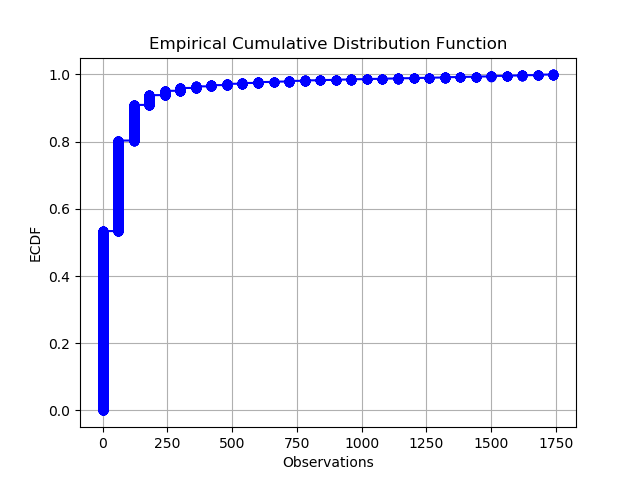

In [85]:
%%spark

#########################################################################################
## There are a lot of negative values in the ecdf I tested, need to be sure this is ok ##
## or else need to do better preprocessing                                             ##
#########################################################################################

def plot_ECDF(sorted_observations, n):
    
    x = sorted_observations.rdd.map(lambda x: x[0]).collect()
    y = np.arange(1, n+1) / n

    # Plot the ECDF
    plt.clf()
    plt.plot(x, y, marker='o', linestyle='-', color='b')
    plt.xlabel('Observations')
    plt.ylabel('ECDF')
    plt.title('Empirical Cumulative Distribution Function')
    #plt.xlim([x[0], x[-1]])
    #plt.ylim([0, 1])
    plt.grid(True)
    plt.show()
    
    
plot_ECDF(df_example, df_example_len)
# Necessary for plot to be shown
%matplot plt 


In [66]:
%%spark
#PSEUDO CODE OF THE FINAL FUNCTION

def level_of_feasibility(df, service_ids, start_station, end_station,
                         changeovers, T, arrival_times, times_for_changeovers, trip_ids):
    '''
    INPUT
    df: dataframe with the planned journeys
    service_ids: list of service_id of each changeover
    start_station: starting point of your journey
    end_station: end point of your journey
    changeovers: list of all the changeovers (stop_id?) of the trip
    T: time you want to arrive before
    arrival_times: list of all the arrival times at each station where you do a changeover
    times for changeovers: list of all the times (theoretical) for each changeover, 0 if not changeovers
    trip_ids:
    
    OUTPUT
    quantile: level of certainty of the feasibility of the trip (to be compared with Q)
    '''
    # CASE NO CHANGEOVERS
    if changeovers == 0:
        if len(service_ids)> 0:
                emp_delays = get_ecdf(df, service_ids[i], end_station_temp) 
        else:
                emp_delays = get_ecdf_trip(df, end_station_temp)
        surplus_time = T - arrival_times[0] #theoretical difference in time of arrival and T
        emp_delays_count = emp_delays.count()
        if emp_delays_count == 0:
            quantile = 1
        else:
            quantile = emp_delays.filter(emp_delays.obs_delay <= surplus_time).count()/emp_delays.count()
       
        return quantile, trip_ids[0], quantile
    
    #CASE AT LEAST ONE CHANGEOVER
    else:
        n_changeovers = len(changeovers) #number of changeovers
        # times_for_changeovers = calculate_time_changeovers(df, service_ids, start_station, end_station, changeovers, T) # list of theoretical time for each changeover
        
        q_changeovers = []
        min_idx = 0
        min_q = 1
        
        for i in range(n_changeovers):
            if i==0:
                start_station_temp = start_station
                end_station_temp = changeovers[i]
            elif i==n_changeovers-1:
                start_station_temp = changeovers[-1]
                end_station_temp = end_station
            else:
                start_station_temp = changeovers[i-1]
                end_station_temp = changeovers[i]
                
            if len(service_ids)> 0:
                emp_delays = get_ecdf(df, service_ids[i], end_station_temp) #ecdf of delay at i-th changeover
            else:
                emp_delays = get_ecdf_trip(df, end_station_temp) #ecdf of delay at i-th changeover
            emp_delays_count = emp_delays.count()
            if emp_delays_count == 0:
                quantile = 1
            else:
                # -120 is to cosider the wlking time between tracks
                quantile =  emp_delays.filter(emp_delays.obs_delay <= times_for_changeovers[i] - 120 ).count()/emp_delays.count() #calculate the % of observed delays that are below the time you have
            
            q_changeovers.append(quantile) #add the level of certainty you catch the i-th changeover based on ecdf of delays
            if quantile < min_q:
                min_q = quantile
                min_idx = i
    
        # once we have the list, we can assume independence of trips and multiply the total quantile as the
        # multiplication of all the quantiles of the list "q_changeovers"
        
        quantile = 1
        for q in q_changeovers:
            quantile *= q
        
        return quantile, trip_ids[min_idx], q_changeovers[min_idx]
    
# REMARKS:
# 1) times_for_changeovers[end] needs to be T-expected_arrival


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

We then test the function above on two example. One with changeovers and one without it (taken from different output of CSA).

## Example without changeovers

In [ ]:
%%spark
# EXAMPLE OF NO-CHANGEOVERS

service_ids = ["85:882:660"]
start_station = "Nürensdorf, Chrüzstrass"
end_station = "Brütten, Hofacher"
T = 1672201680
arrival_times = [1672201620]
changeovers = 0
times_for_changeovers = 0

qu, trip_id, _ = level_of_feasibility(df, [], start_station, end_station,
                         changeovers, T, arrival_times, times_for_changeovers)
qu

## Example with changeovers

In [67]:
%%spark

#['3144.TA.26-6-j20-1.39.H', Timestamp('2023-05-26 10:39:00'), '8591230', Timestamp('2023-05-26 10:51:00'), '8587349'], 
#['1967.TA.26-14-A-j20-1.15.H', Timestamp('2023-05-26 10:54:00'), '8587349', Timestamp('2023-05-26 11:04:00'), '8573710'], 
trip_ids = ['3144.TA.26-6-j20-1.39.H', '1967.TA.26-14-A-j20-1.15.H']
stop_ids = ['8591230', '8587349', '8573710']

# Get service id from trip id
service_ids = [dict_service_trip_id[t] for t in trip_ids]
print(service_ids)

# Get stop name from stop id
stop_names = [dict_stop_name_id[s] for s in stop_ids]
print(stop_names)


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['TA+b09kv', 'TA+b14p0']
['Zürich, Kirche Fluntern', 'Zürich, Bahnhofquai/HB', 'Zürich Wiedikon, Bahnhof']

Here we wrote a function able to create a dictionary of the useful information provided as output by the CSA algorithm. This is required to have the data in the right way to be feed into the level_of_feasibility function.

In [109]:
%%spark

#itinerary = CSA("8591230", "8573710", arrival_time=time(11,10,0))
itinerary_example = [['3144.TA.26-6-j20-1.39.H', datetime(2023, 5, 26, 10, 39, 0), '8591230', datetime(2023, 5, 26, 10, 51, 0), '8587349'],
 ['1967.TA.26-14-A-j20-1.15.H', datetime(2023, 5, 26, 10, 54, 0), '8587349', datetime(2023, 5, 26, 11, 4, 0), '8573710'],
 [None, datetime(2023, 5, 26, 11, 10, 0), '8573710', None, None]]

def extract_info_from_itinerary(itinerary):
    result = {}
    result['changeovers'] = []
    result['service_ids'] = []
    result['arrival_times'] = []
    result['start_times'] = []
    result['trip_ids'] = []
    departure_times = []
    for i in range(len(itinerary)):
        if i == 0:
            result['start_station'] = dict_stop_name_id[itinerary[i][2]]
        elif i == len(itinerary) - 1:
            result['end_station'] = dict_stop_name_id[itinerary[i][2]]
            result['T'] = time.mktime(itinerary[i][1].timetuple())
        else:
            result['changeovers'].append(dict_stop_name_id[itinerary[i][2]])
        
        if i < len(itinerary) - 1:
            result['start_times'].append(time.mktime(itinerary[i][1].timetuple()))
            result['arrival_times'].append(time.mktime(itinerary[i][3].timetuple()))
            result['service_ids'].append(dict_service_trip_id[itinerary[i][0]])
            result['trip_ids'].append(itinerary[i][0])
        
        if i > 0:
            departure_times.append(time.mktime(itinerary[i][1].timetuple()))
    
    result['times_for_changeovers'] = [departure_times[i] - result['arrival_times'][i] for i in range(len(departure_times))]
        
    return result

res = extract_info_from_itinerary(itinerary_example)
print(res)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

{'changeovers': ['Zürich, Bahnhofquai/HB'], 'service_ids': ['TA+b09kv', 'TA+b14p0'], 'arrival_times': [1685091060.0, 1685091840.0], 'start_times': [1685090340.0, 1685091240.0], 'trip_ids': ['3144.TA.26-6-j20-1.39.H', '1967.TA.26-14-A-j20-1.15.H'], 'start_station': 'Zürich, Kirche Fluntern', 'end_station': 'Zürich Wiedikon, Bahnhof', 'T': 1685092200.0, 'times_for_changeovers': [180.0, 360.0]}

Then, we have the following function that describe to the user the suggested trip (which means of transport, at which station, at what hour, etc ...).

In [134]:
%%spark

def describe_path_to_take(res, trip_route_dict, min_qu, act_qu):
    print("Query:")
    print(f'From {res["start_station"]} to {res["end_station"]}')
    print(f'Arrive before {datetime.utcfromtimestamp(res["T"]).strftime("%Y-%m-%d %H:%M:%S")} with a confidence of at least {min_qu}')
    print('-----------------------------------------------------------------')
    print("Response:")
    if min_qu > act_qu:
        print(f"Confidence interval of {act_qu} is too low, must find another path")
        return False
    
    for i in range(len(res['trip_ids'])):
        if i == 0:
            print(f'Trip {i+1} ({trip_route_dict[res["trip_ids"][i]]}): {res["start_station"]} ({datetime.utcfromtimestamp(res["start_times"][i]).strftime("%Y-%m-%d %H:%M:%S")}) -> {res["changeovers"][i]} ({datetime.utcfromtimestamp(res["arrival_times"][i]).strftime("%Y-%m-%d %H:%M:%S")})')
        elif i == len(res['trip_ids']) - 1:
            print(f'Trip {i+1} ({trip_route_dict[res["trip_ids"][i]]}): {res["changeovers"][i-1]} ({datetime.utcfromtimestamp(res["start_times"][i]).strftime("%Y-%m-%d %H:%M:%S")}) -> {res["end_station"]} ({datetime.utcfromtimestamp(res["arrival_times"][i]).strftime("%Y-%m-%d %H:%M:%S")})')
        else:
            print(f'Trip {i+1} ({trip_route_dict[res["trip_ids"][i]]}): {res["changeovers"][i-1]} ({datetime.utcfromtimestamp(res["start_times"][i]).strftime("%Y-%m-%d %H:%M:%S")}) -> {res["changeovers"][i]} ({datetime.utcfromtimestamp(res["arrival_times"][i]).strftime("%Y-%m-%d %H:%M:%S")})')
        
    print(f'You will arrive at {res["end_station"]} before {datetime.utcfromtimestamp(res["T"]).strftime("%Y-%m-%d %H:%M:%S")} with confidence {act_qu}!')
    return True

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [135]:
%%spark
resp = describe_path_to_take(res, transport_name_dict, 0.95, 0.94)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Query:
From Zürich, Kirche Fluntern to Zürich Wiedikon, Bahnhof
Arrive before 2023-05-26 09:10:00 with a confidence of at least 0.95
-----------------------------------------------------------------
Response:
Confidence interval of 0.94 is too low, must find another path

Let's now try with the other working trip with changeovers

In [125]:
%%spark

min_qu = 0.95
# Calculate the feasibility of a path
qu, trip_id, _ = level_of_feasibility(df, [], res['start_station'], res['end_station'],
                         res['changeovers'], res['T'], res['arrival_times'], res['times_for_changeovers'], res['trip_ids'])

describe_path_to_take(res, transport_name_dict, min_qu, qu)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Query:
From Zürich, Kirche Fluntern to Zürich Wiedikon, Bahnhof
Arrive before 2023-05-26 09:10:00 with a confidence of at least 0.95
-----------------------------------------------------------------
Response:
Trip 1 (Tram 6): Zürich, Kirche Fluntern (2023-05-26 08:39:00) -> Zürich, Bahnhofquai/HB (2023-05-26 08:51:00)
Trip 2 (Tram 14): Zürich, Bahnhofquai/HB (2023-05-26 08:54:00) -> Zürich Wiedikon, Bahnhof (2023-05-26 09:04:00)
You will arrive at Zürich Wiedikon, Bahnhof before 2023-05-26 09:10:00 with confidence 0.9581413210445469!

In [40]:
%spark cleanup